# License
our code uses the MIT license. Part of our implementation is inspired by the code from [habitat_sim (MIT license)](https://aihabitat.org/), [LSeg (MIT license)](https://github.com/isl-org/lang-seg), and [CLIP (MIT license)](https://github.com/openai/CLIP). We would like to express our gratitude to the developers of these projects.

### Conda Environment and GPU Setup

In [1]:
import os, sys
# point at your active env (vlmaps6)
env_bin = os.path.join(sys.prefix, "bin")
# put it first in PATH
os.environ["PATH"] = env_bin + os.pathsep + os.environ.get("PATH", "")
print("New PATH starts with:", os.environ["PATH"].split(os.pathsep)[0])
print("This notebook is running under:", sys.executable)
!which conda

New PATH starts with: /home/jovyan/teaching_material/msc/envs/vlmaps6/bin
This notebook is running under: /home/jovyan/teaching_material/msc/envs/vlmaps6/bin/python
/home/jovyan/teaching_material/msc/envs/vlmaps6/bin/conda


In [2]:
# Should be at least CUDA 11.0 or higher
!nvidia-smi

Mon Jun  9 17:21:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:C2:00.0 Off |                    0 |
| N/A   30C    P0             69W /  300W |    4526MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Ensure that you use CUDA 11.0 and it works!!!
import torch
print("PyTorch version:", torch.__version__) # Should output "Pytorch version: 1.7.1"
print("CUDA toolkit:", torch.version.cuda)
print("Device SM capability:", torch.cuda.get_device_capability())
print(torch.cuda.is_available()) # Should return "True" if GPU support is active

PyTorch version: 2.3.1+cu118
CUDA toolkit: 11.8
Device SM capability: (8, 0)
True


# Settings

In [4]:
REPO_NEEDS_SETUP = False # Set to 'True' ONLY ONCE -> to download data etc.
USE_OPENSEED = False

# VLMap Creation

## Download the data and install dependencies

In [5]:
# !pip install tqdm
# !pip install "imageio[ffmpeg]"
# !pip install opencv-python
# Windows + Linux
# !pip install git+https://github.com/openai/CLIP.git
# !pip install pandas
# !pip install timm
# !pip install pytorch-lightning
# !pip uninstall -y pillow
# !pip install pillow==9.4.0
# !pip installpip install --upgrade "pytorch-lightning==2.3.3"
# !pip install lightning-fabric
# !conda install -c conda-forge cudatoolkit-dev -y
# !python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'

In [6]:
# WINDOWS: pwd is not supported -> set paths manually
root_dir = !pwd
root_dir = root_dir[0]

In [7]:
if REPO_NEEDS_SETUP:
    !mkdir -p data
    %cd data
    # !gdown --version # check if package installed
    !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu # 2.75G image data (1159 frames)
    # WINDOWS: comment out the !unzip line and unzip it manually
    # WINDOWS: MAKE SURE that the LAST "5LpN3gDmAk7_1" folder is at same level as the .zip (unzipping will give another 5LpN3gDmAk7_1 within a 5LpN3gDmAk7_1 folder)
    !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
    %cd ..

In [8]:
data_dir = os.path.join(root_dir, "data", "5LpN3gDmAk7_1")

In [9]:
print(data_dir) # should end with "MSc-Thesis/data/5LpN3gDmAk7_1"
print(root_dir) # should end with "MSc-Thesis"

/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1
/home/jovyan/teaching_material/msc/MSc-Thesis


## Visualize the Dataset

In [10]:
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

if "google.colab" in sys.modules:
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_vis = (depth / 10 * 255).astype(np.uint8)

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)

In [11]:
create_video(data_dir, root_dir, fps=30)

In [12]:
# show rgb and depth
show_videos([root_dir + "/rgb.mp4", root_dir + "/depth.mp4"])

## Download LSeg checkpoint

In [13]:
if REPO_NEEDS_SETUP:
    %cd {root_dir + "/lseg"}
    !mkdir checkpoints
    %cd checkpoints
    !gdown 1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb
    !ls

In [14]:
%cd {root_dir}

/home/jovyan/teaching_material/msc/MSc-Thesis


## VLMap Creation
It takes around 20 minutes to build a VLMap with around 1000 RGBD frames. We also provide a pre-built VLMap. Skip to the Landmark Indexing part of the code to directly try our map.

In [15]:
# setup parameters
# @markdown meters per cell size
cs = 0.05 # @param {type: "number"}
# @markdown map resolution (gs x gs)
gs = 1000 # @param {type: "integer"}
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"}
# @markdown depth pixels subsample rate
depth_sample_rate = 100 # @param {type: "integer"}
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"}

In [16]:
import os, sys
print("cwd =", os.getcwd())
print("\n".join(sys.path))

cwd = /home/jovyan/teaching_material/msc/MSc-Thesis
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python38.zip
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/lib-dynload

/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages
/home/jovyan/Hierarchical-Localization
/home/jovyan/teaching_material/msc/OpenSeeD/openseed/body/encoder/ops
/home/jovyan/teaching_material/msc/OpenSeeD


In [17]:
import importlib

In [18]:
from utils.clip_mapping_utils import (
    load_pose, load_semantic, load_obj2cls_dict, save_map,
    cvt_obj_id_2_cls_id, depth2pc,
    transform_pc, get_sim_cam_mat,
    pos2grid_id, project_point
)
print("✅ Imported from:", importlib.import_module("utils.clip_mapping_utils").__file__)

__file__:  /home/jovyan/teaching_material/msc/MSc-Thesis/examples/context.py
imported path: /home/jovyan/teaching_material/msc/MSc-Thesis
✅ Imported from: /home/jovyan/teaching_material/msc/MSc-Thesis/utils/clip_mapping_utils.py


In [19]:
from tools.call_openseed_text    import openseed_text

In [24]:
import os, sys
print("cwd =", os.getcwd())
print("\n".join(sys.path))

cwd = /home/jovyan/teaching_material/msc/MSc-Thesis
/home/jovyan/teaching_material/msc/OpenSeeD
/home/jovyan/teaching_material/msc/MSc-Thesis
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python38.zip
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8
/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/lib-dynload

/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages
/home/jovyan/Hierarchical-Localization
/home/jovyan/teaching_material/msc/OpenSeeD/openseed/body/encoder/ops
/home/jovyan/teaching_material/msc/OpenSeeD


In [25]:
# # 2) Insert your local OpenSeeD repo at the front of sys.path
# new_openseed_path = "/home/jovyan/teaching_material/msc/OpenSeeD"
# sys.path.insert(0, new_openseed_path)
# print("\nAdded new path to top of sys.path:")
# print("  ", sys.path[0])

In [26]:
import os, sys

# 1) Compute your OpenSeeD clone root
NB_DIR       = os.getcwd()  # /home/jovyan/teaching_material/msc/MSc-Thesis
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))

# 2) Add both:
#    • the 'tools' folder so you can import openseed_dump_pixels as a top-level module
#    • the package root so that `from openseed import …` still works
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# 3) Now import!
from openseed_dump_pixels import load_model
print(load_model)

/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


<function load_model at 0x7f87271281f0>


In [27]:
from openseed_dump_pixels import load_model
print(load_model)

<function load_model at 0x7f87271281f0>


In [32]:
from openseed_dump_pixels import load_model, pixel_features_from_array
# from call_openseed_text    import openseed_text

In [54]:
import os, sys

# 1) Where is your notebook sitting?
NB_DIR = os.getcwd()  
#    e.g. "/home/jovyan/teaching_material/msc/MSc-Thesis"

# 2) Point at the OpenSeeD folder (parent of tools/ and configs/)
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, "..", "OpenSeeD"))
# sys.path.insert(0, OPENSEED_ROOT)
# sys.path.insert(0, os.path.join(OPENSEED_ROOT, "tools"))

In [55]:
cfg_path    = os.path.join(OPENSEED_ROOT, "configs", "openseed",
                           "openseed_swinl_lang_decouple.yaml")
weight_path = os.path.join(OPENSEED_ROOT, "weights",
                           "openseed_swinl_pano_sota.pt")

print("cfg exists?   ", os.path.exists(cfg_path))
print("weight exists?", os.path.exists(weight_path))

cfg exists?    True
weight exists? True


In [62]:
# @title Helper functions for VLMap Creation

import os
import math

import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import clip

from utils.clip_mapping_utils import load_pose, load_semantic, load_obj2cls_dict, save_map, cvt_obj_id_2_cls_id, depth2pc, transform_pc, get_sim_cam_mat, pos2grid_id, project_point

from lseg.modules.models.lseg_net import LSegEncNet
from lseg.additional_utils.models import resize_image, pad_image, crop_image

device = "cuda" if torch.cuda.is_available() else "cpu"

def create_feat_map_batch(img_save_dir, camera_height, cs=0.05, gs=1000, depth_sample_rate=100, use_openseed=False, openseed_cfg=None, openseed_weight=None):
    mask_version = 1 # 0, 1

    crop_size = 480 # 480
    base_size = 520 # 520
    lang = "door,chair,ground,ceiling,other"
    labels = lang.split(",")

    # loading models
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)

    if use_openseed:
        # manual loading
        # # ———————— Load the full OpenSeeD pipeline ————————
        openseed_cfg    = openseed_cfg    or os.path.join(OPENSEED_ROOT, "configs/openseed/openseed_swinl_lang_decouple.yaml") # openseed_swint_lang.yaml
        openseed_weight = openseed_weight or os.path.join(OPENSEED_ROOT, "weights/openseed_swinl_pano_sota.pt")

        device = "cuda" if torch.cuda.is_available() else "cpu"

        # official function loading
        model = load_model(openseed_cfg, openseed_weight, device)
    
    else:
        clip_version = "ViT-B/32"
        clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                        'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
        print("Loading CLIP model...")
        clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
        clip_model.to(device).eval()
        lang_token = clip.tokenize(labels)
        lang_token = lang_token.to(device)
        with torch.no_grad():
            text_feats = clip_model.encode_text(lang_token)
            text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
        text_feats = text_feats.cpu().numpy()
        model = LSegEncNet(lang, arch_option=0,
                            block_depth=0,
                            activation='lrelu',
                            crop_size=crop_size)
        model_state_dict = model.state_dict()
        pretrained_state_dict = torch.load("lseg/checkpoints/demo_e200.ckpt")
        pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
        model_state_dict.update(pretrained_state_dict)
        model.load_state_dict(pretrained_state_dict)
        model.eval()        
        model = model.cuda()

    norm_mean= [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    padding = [0.0] * 3
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    print(f"loading scene {img_save_dir}")
    rgb_dir = os.path.join(img_save_dir, "rgb")
    depth_dir = os.path.join(img_save_dir, "depth")
    pose_dir = os.path.join(img_save_dir, "pose")
    semantic_dir = os.path.join(img_save_dir, "semantic")
    obj2cls_path = os.path.join(img_save_dir, "obj2cls_dict.txt")

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    semantic_list = sorted(os.listdir(semantic_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pose_list = [os.path.join(pose_dir, x) for x in pose_list]
    semantic_list = [os.path.join(semantic_dir, x) for x in semantic_list]


    map_save_dir = os.path.join(img_save_dir, "map")
    os.makedirs(map_save_dir, exist_ok=True)
    color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy")
    gt_save_path = os.path.join(map_save_dir, f"grid_{mask_version}_gt.npy")

    prefix = "openseed" if use_openseed else "lseg"
    grid_save_path   = os.path.join(map_save_dir, f"grid_{prefix}_{mask_version}.npy")
    weight_save_path = os.path.join(map_save_dir, f"weight_{prefix}_{mask_version}.npy")
    
    # grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy")
    # weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy")
    obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")

    obj2cls = load_obj2cls_dict(obj2cls_path)

    # initialize a grid with zero position at the center
    color_top_down_height = (camera_height + 1) * np.ones((gs, gs), dtype=np.float32)
    color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
    gt = np.zeros((gs, gs), dtype=np.int32)
    feat_dim = 256 if use_openseed else clip_feat_dim
    grid = np.zeros((gs, gs, feat_dim), dtype=np.float32)
    # grid = np.zeros((gs, gs, clip_feat_dim), dtype=np.float32)
    obstacles = np.ones((gs, gs), dtype=np.uint8)
    weight = np.zeros((gs, gs), dtype=float)

    save_map(color_top_down_save_path, color_top_down)
    save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)

    tf_list = []
    data_iter = zip(rgb_list, depth_list, semantic_list, pose_list)
    pbar = tqdm(total=len(rgb_list))
    # load all images and depths and poses
    for data_sample in data_iter:
        rgb_path, depth_path, semantic_path, pose_path = data_sample
        
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        # read pose
        pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right
        rot_ro_cam = np.eye(3)
        rot_ro_cam[1, 1] = -1
        rot_ro_cam[2, 2] = -1
        rot = rot @ rot_ro_cam
        pos[1] += camera_height


        pose = np.eye(4)
        pose[:3, :3] = rot
        pose[:3, 3] = pos.reshape(-1)

        tf_list.append(pose)
        if len(tf_list) == 1:
            init_tf_inv = np.linalg.inv(tf_list[0]) 

        tf = init_tf_inv @ pose

        # read depth
        depth = load_depth(depth_path)

        # read semantic
        semantic = load_semantic(semantic_path)
        semantic = cvt_obj_id_2_cls_id(semantic, obj2cls)

        if use_openseed:
            rgb_array = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            # 
            # pix_feats = pix_feats_np[None]  # → (1, C, H, W)
            # # pix_feats = openseed_feats_from_array(bgr, model)   # (1,256,H,W)

    
            # 2) Run OpenSeeD’s in‐memory extractor
            # pix_np is now (C,H,W), float32, L2-normalized per-channel
            pix_np = pixel_features_from_array(model, rgb_array, long_edge=512)  # → (C, H, W)
    
            # 3) If OpenSeeD’s output resolution ≠ RGB resolution, resize:
            if pix_np.shape[1:] != rgb.shape[:2]:
                pix_np = cv2.resize(
                    pix_np.transpose(1, 2, 0),               # (H, W, C)
                    (rgb.shape[1], rgb.shape[0]),             # (width, height)
                    interpolation=cv2.INTER_LINEAR
                ).transpose(2, 0, 1)                         # back to (C, H, W)
    
            # 4) Add batch dimension → (1, C, H, W)
            pix_feats = pix_np.astype(np.float32)[None]
        else:
            pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)
        
        # transform all points to the global frame
        pc, mask = depth2pc(depth)
        shuffle_mask = np.arange(pc.shape[1]) 
        np.random.shuffle(shuffle_mask)
        shuffle_mask = shuffle_mask[::depth_sample_rate]
        mask = mask[shuffle_mask]
        pc = pc[:, shuffle_mask]
        pc = pc[:, mask]
        pc_global = transform_pc(pc, tf)

        rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1])
        feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3])

        # project all point cloud onto the ground
        for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
            x, y = pos2grid_id(gs, cs, p[0], p[2])

            # ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
            if x >= obstacles.shape[0] or y >= obstacles.shape[1] or \
                x < 0 or y < 0 or p_local[1] < -0.5:
                continue

            rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
            rgb_v = rgb[rgb_py, rgb_px, :]
            semantic_v = semantic[rgb_py, rgb_px]
            if semantic_v == 40:
                semantic_v = -1
            
            # when the projected location is already assigned a color value before, overwrite if the current point has larger height
            if p_local[1] < color_top_down_height[y, x]:
                color_top_down[y, x] = rgb_v
                color_top_down_height[y, x] = p_local[1]
                gt[y, x] = semantic_v

            # average the visual embeddings if multiple points are projected to the same grid cell
            px, py, pz = project_point(feat_cam_mat, p_local)
            if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
                feat = pix_feats[0, :, py, px]
                grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)
                weight[y, x] += 1
            
            # build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
            if p_local[1] > camera_height:
                continue
            obstacles[y, x] = 0
        pbar.update(1)

    save_map(color_top_down_save_path, color_top_down)
    save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(weight_save_path, weight)
    save_map(obstacles_save_path, obstacles)


def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy()
    image = transform(image).unsqueeze(0).cuda()
    img = image[0].permute(1,2,0)
    img = img * 0.5 + 0.5
    
    batch, _, h, w = image.size()
    stride_rate = 2.0/3.0
    stride = int(crop_size * stride_rate)

    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height


    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size:
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels)
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size:
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else:
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size()
        assert(ph >= height and pw >= width)
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1
        with torch.cuda.device_of(image):
            with torch.no_grad():
                outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda()
                logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda()
            count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda()
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad():
                    mask_preds, logit_preds = model(pad_crop_img.to(device), labels)
                cropped = crop_image(mask_preds, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logit_preds, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]

    return outputs

In [64]:
create_feat_map_batch(data_dir, camera_height=camera_height, cs=cs, gs=gs, depth_sample_rate=depth_sample_rate, use_openseed=USE_OPENSEED)

cuda
Loading CLIP model...
loading scene /home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/color_top_down_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/grid_1_gt.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/grid_lseg_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/weight_lseg_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/obstacles.npy is saved.




  0%|          | 0/1159 [00:00<?, ?it/s]

  0%|          | 1/1159 [00:01<19:57,  1.03s/it]

  0%|          | 2/1159 [00:01<18:49,  1.02it/s]

  0%|          | 3/1159 [00:02<17:27,  1.10it/s]

  0%|          | 4/1159 [00:03<17:06,  1.13it/s]

  0%|          | 5/1159 [00:04<17:11,  1.12it/s]

  1%|          | 6/1159 [00:05<17:19,  1.11it/s]

  1%|          | 7/1159 [00:06<17:44,  1.08it/s]

  1%|          | 8/1159 [00:07<18:13,  1.05it/s]

  1%|          | 9/1159 [00:08<18:18,  1.05it/s]

  1%|          | 10/1159 [00:09<17:43,  1.08it/s]

  1%|          | 11/1159 [00:10<17:50,  1.07it/s]

  1%|          | 12/1159 [00:11<17:56,  1.07it/s]

  1%|          | 13/1159 [00:12<17:43,  1.08it/s]

  1%|          | 14/1159 [00:12<17:10,  1.11it/s]

  1%|▏         | 15/1159 [00:13<16:40,  1.14it/s]

  1%|▏         | 16/1159 [00:14<16:08,  1.18it/s]

  1%|▏         | 17/1159 [00:15<15:39,  1.22it/s]

  2%|▏         | 18/1159 [00:16<15:14,  1.25it/s]

  2%|▏         | 19/1159 [00:16<14:45,  1.29it/

/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/color_top_down_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/grid_1_gt.npy is saved.


100%|██████████| 1159/1159 [17:43<00:00,  1.09it/s]

/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/grid_lseg_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/weight_lseg_1.npy is saved.
/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/map/obstacles.npy is saved.


# Landmark Indexing

## Load packages

In [66]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.clip_mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import clip

## Setup Load Paths

Set `use_self_built_map` to False to use the map we provided, and set it to True if you want to try the map you built in the `VLMap Creation` section.

In [67]:
use_self_built_map = True
map_save_dir = os.path.join(data_dir, "map_correct")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")

prefix = "openseed" if USE_OPENSEED else "lseg"
grid_save_path = os.path.join(map_save_dir, f"grid_{prefix}_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")

## Show Obstacle Map

[0 1]


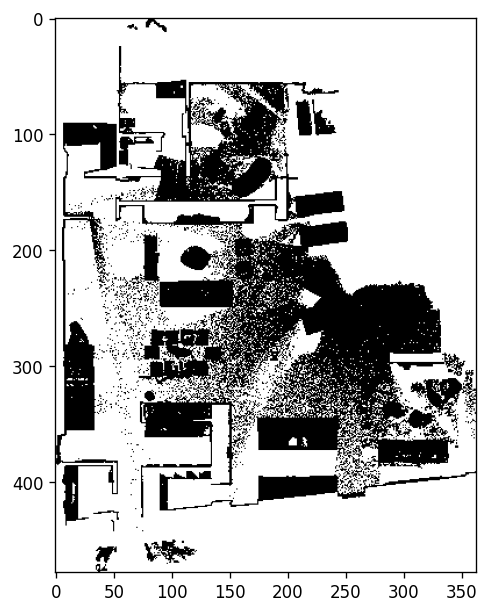

In [68]:
obstacles = load_map(obstacles_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

you can see that the obstacles are black and the free space is white. You can also observe noisy black points lying on the ground. These points are caused by the slope or different floor heights in the scene.

## Show Top-Down Color Map

  0%|          | 0/1159 [27:48<?, ?it/s]


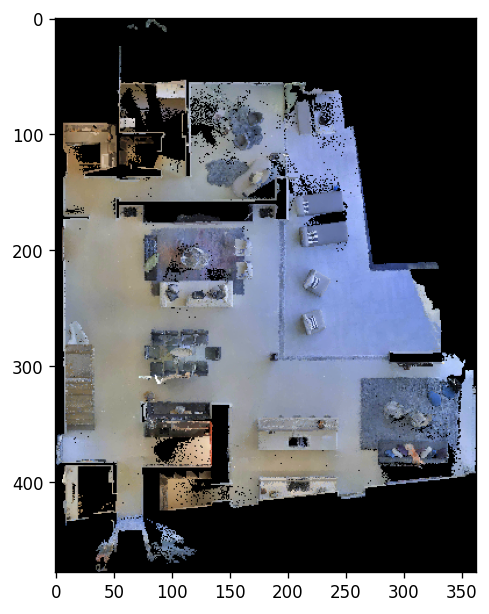

In [69]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()

the color map is created by projecting the color-augmented point cloud to the floor.

## Show Landmark Indexing Results

In [70]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [71]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]

In [72]:
# L2 Normalize the grid features
# reshape to (H*W, D), compute per-cell norms, avoid divide-by-zero, renormalize
H, W, D = grid.shape
flat     = grid.reshape(-1, D).astype(np.float32)
norms    = np.linalg.norm(flat, axis=1, keepdims=True)
norms[norms == 0] = 1.0
flat    /= norms
grid     = flat.reshape(H, W, D)

we use the text form of all semantic categories provided by the Matterport3D dataset as prompts to the VLMap and localize all categories in the map. We filter out "floor" category.

In [73]:
# import os, sys
# # Adjust this to wherever your “tools/” folder actually is:
# sys.path.insert(0, "/home/jovyan/teaching_material/msc/MSc-Thesis")
# from tools.call_openseed_text import openseed_text

In [74]:
# !pip list

In [75]:
from tools.call_openseed_text import openseed_text

(478, 363)


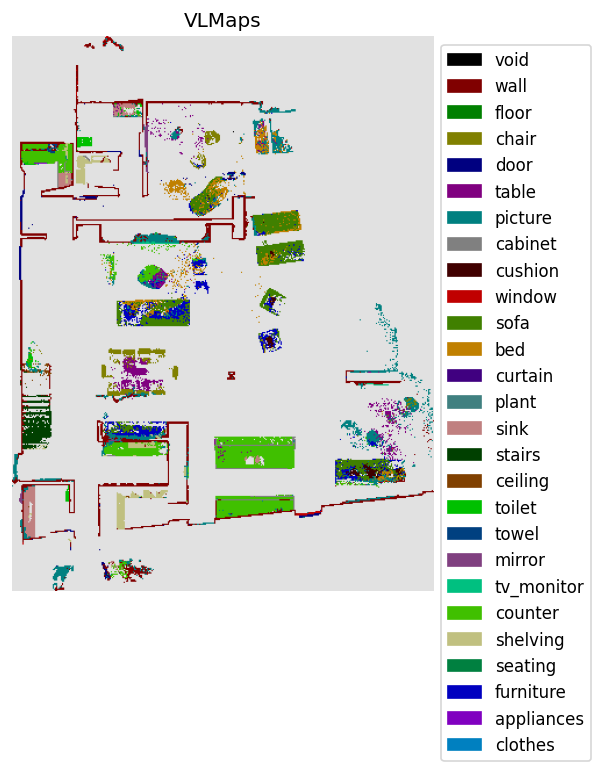

In [76]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = mp3dcat
if USE_OPENSEED:
    text_feats = openseed_text(lang)
    text_feats = text_feats.astype(np.float32)
    tnorms     = np.linalg.norm(text_feats, axis=1, keepdims=True)
    tnorms[tnorms == 0] = 1.0
    text_feats /= tnorms
else:
    # vanilla CLIP -> returns (K,512)
    text_feats = get_text_feats(lang, clip_model, clip_feat_dim)   # 512-D

if grid.shape[-1] != text_feats.shape[1]:
    text_feats = text_feats[:, :grid.shape[-1]]  # 512 -> 256

# text_feats = get_text_feats(lang, clip_model, clip_feat_dim)   # 512-D
map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

## Open-Vocabulary Landmark Indexing

In addition to using the fixed set of categories, we can also use customized text prompts to the map and index their corresponding locations. You could play around with the `lang` variable below by providing your own prompt. 

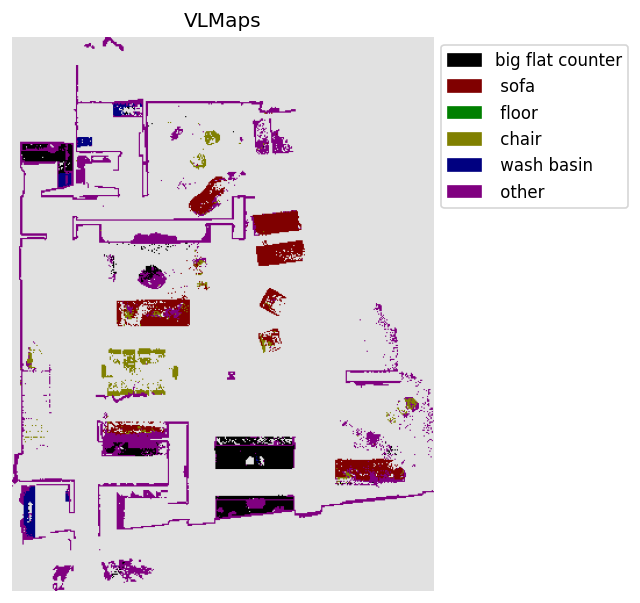

In [77]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "big flat counter, sofa, floor, chair, wash basin, other" # @param {type: "string"} # wash basin instead of seating, wall <- other
lang = lang.split(",")
if USE_OPENSEED:
    text_feats = openseed_text(lang) # (K,256)
else:
    text_feats = get_text_feats(lang, clip_model, clip_feat_dim) # (K,512)

# make dimensions match the grid
if grid.shape[-1] != text_feats.shape[1]:
    text_feats = text_feats[:, :grid.shape[-1]] # truncate 512 -> 256

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

# Evaluation

Current working directory: /home/jovyan/teaching_material/msc/MSc-Thesis
Evaluation Metrics:
Per-class IoU:
  door: 0.998
  chair: 0.017
  ground: 0.786
  ceiling: 0.000
  other: 0.014
Mean IoU: 0.363
Pixel Accuracy: 0.962


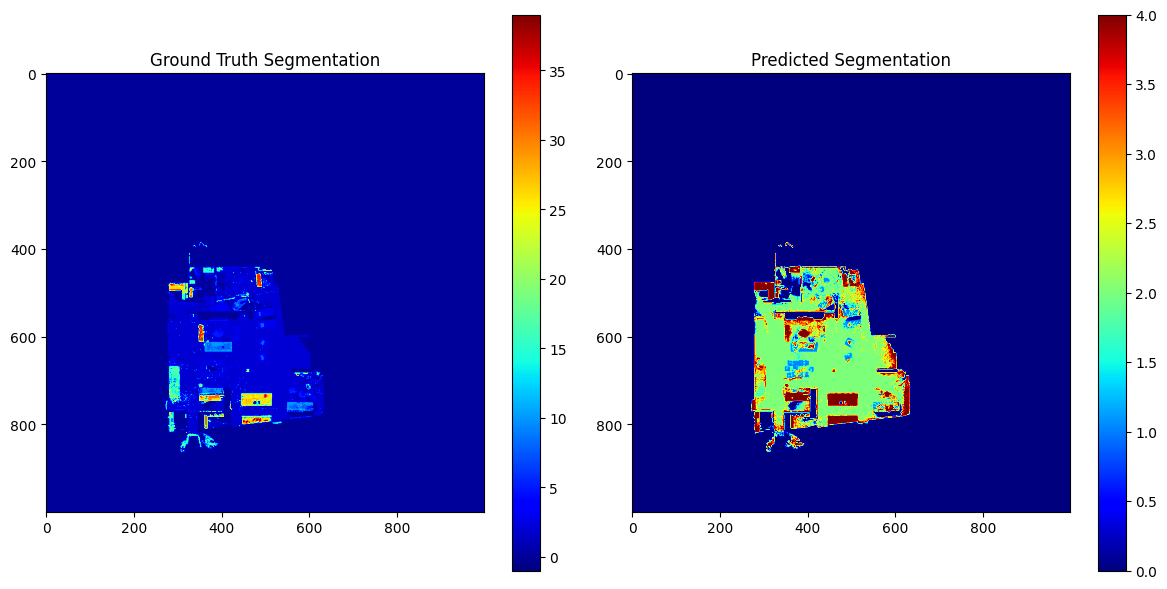

In [78]:
os.chdir(root_dir)
print("Current working directory:", os.getcwd())

# Build the map directory path dynamically
base_map_dir = os.path.join(data_dir, "map")

# Define file paths relative to the base_map_dir
gt_path = os.path.join(base_map_dir, "grid_1_gt.npy")       # Ground truth segmentation map
grid_path = os.path.join(base_map_dir, f"grid_{prefix}_1.npy")

def compute_iou(gt, pred, num_classes):
    """Compute per-class Intersection over Union (IoU)."""
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(gt == cls, pred == cls).sum()
        union = np.logical_or(gt == cls, pred == cls).sum()
        if union == 0:
            ious.append(np.nan)  # or 0 if you prefer
        else:
            ious.append(intersection / union)
    return ious

def compute_pixel_accuracy(gt, pred):
    """Compute overall pixel accuracy."""
    valid = gt >= 0  # assuming negative labels (if any) are ignore labels
    correct = (gt == pred)[valid].sum()
    total = valid.sum()
    return correct / total

def main():
    # Load ground truth segmentation and grid features.
    gt = np.load(gt_path)    # Expected shape: (gs, gs)
    grid = np.load(grid_path)  # Expected shape: (gs, gs, clip_feat_dim)
    
    # Set up CLIP to extract text features.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_version = "ViT-B/32"
    model, _ = clip.load(clip_version, device=device)
    model.eval()
    
    # Use the same class labels as in your VLMap creation.
    class_labels = ["door", "chair", "ground", "ceiling", "other"]
    
    # Tokenize and encode text to get text features.
    if USE_OPENSEED:
        text_features = openseed_text(class_labels)          # (5,256)
    else:
        lang_token = clip.tokenize(class_labels).to(device)
        with torch.no_grad():
            text_features = model.encode_text(lang_token)    # (5,512)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu().numpy()  # Shape: (5, clip_feat_dim)

    if grid.shape[-1] != text_features.shape[1]:
        text_features = text_features[:, :grid.shape[-1]]

    # Compute predicted segmentation from grid features.
    # grid has shape (gs, gs, clip_feat_dim). Reshape it to (-1, clip_feat_dim)
    gs, _, feat_dim = grid.shape
    grid_feats = grid.reshape(-1, feat_dim)  # Shape: (gs*gs, feat_dim)
    
    # Compute similarity scores between grid features and text features.
    scores = grid_feats @ text_features.T   # Shape: (gs*gs, 5)
    
    # Predicted class per grid cell is the argmax over similarity scores.
    pred_labels = np.argmax(scores, axis=1)  # Shape: (gs*gs,)
    pred_labels = pred_labels.reshape(gt.shape)  # Reshape back to map dimensions
    
    # Compute evaluation metrics.
    num_classes = len(class_labels)
    ious = compute_iou(gt, pred_labels, num_classes)
    pixel_acc = compute_pixel_accuracy(gt, pred_labels)
    mean_iou = np.nanmean(ious)
    
    # Print evaluation results.
    print("Evaluation Metrics:")
    print("Per-class IoU:")
    for label, iou in zip(class_labels, ious):
        print(f"  {label}: {iou:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")
    print(f"Pixel Accuracy: {pixel_acc:.3f}")
    
    # Visualize the ground truth and predicted segmentation side by side.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Segmentation")
    plt.imshow(gt, cmap="jet")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(pred_labels, cmap="jet")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Current working directory: /home/jovyan/teaching_material/msc/MSc-Thesis
Evaluation Metrics:
Per-class IoU:
  void: 1.000
  wall: 0.296
  floor: 0.814
  chair: 0.115
  door: 0.059
  table: 0.044
  picture: 0.033
  cabinet: 0.106
  cushion: 0.222
  window: 0.000
  sofa: 0.122
  bed: 0.000
  curtain: 0.000
  chest_of_drawers: nan
  plant: 0.000
  sink: 0.537
  stairs: 0.355
  ceiling: 0.001
  toilet: 0.592
  stool: 0.000
  towel: 0.222
  mirror: 0.136
  tv_monitor: 0.149
  shower: 0.000
  column: 0.000
  bathtub: nan
  counter: 0.529
  fireplace: nan
  lighting: nan
  beam: nan
  railing: nan
  shelving: 0.394
  blinds: nan
  gym_equipment: nan
  seating: 0.000
  board_panel: 0.000
  furniture: 0.000
  appliances: 0.057
  clothes: 0.000
  objects: 0.000
Mean IoU: 0.181
Pixel Accuracy: 0.974


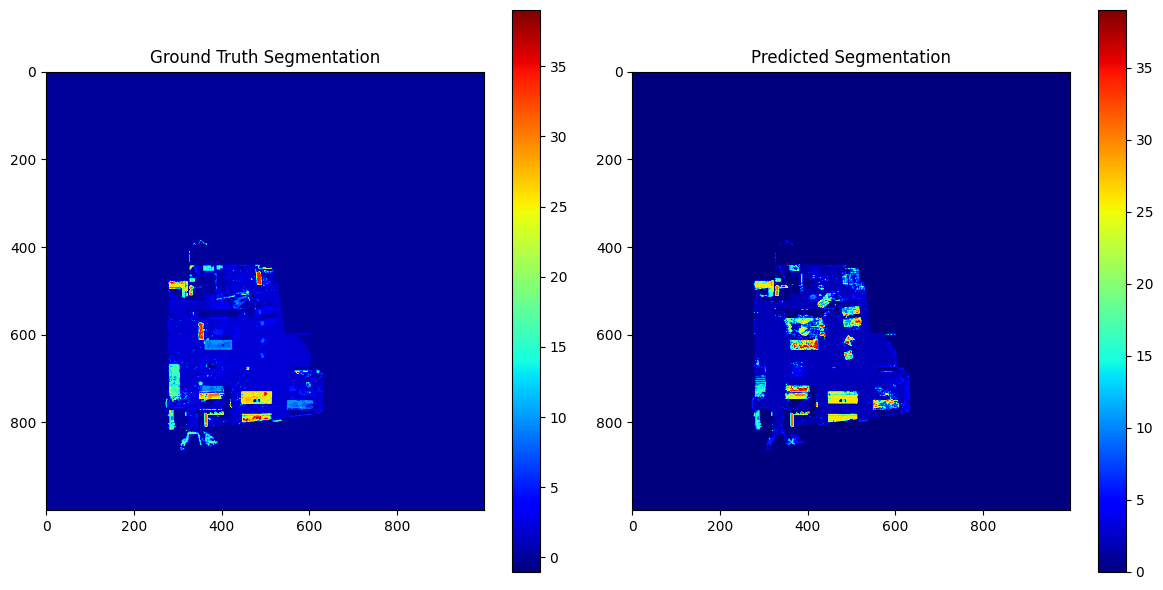

In [79]:
os.chdir(root_dir)
print("Current working directory:", os.getcwd())

# Build the map directory path dynamically
base_map_dir = os.path.join(data_dir, "map")

# Define file paths relative to the base_map_dir
gt_path = os.path.join(base_map_dir, "grid_1_gt.npy")       # Ground truth segmentation map
grid_path = os.path.join(base_map_dir, f"grid_{prefix}_1.npy")

def compute_iou(gt, pred, num_classes):
    """Compute per-class Intersection over Union (IoU)."""
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(gt == cls, pred == cls).sum()
        union = np.logical_or(gt == cls, pred == cls).sum()
        if union == 0:
            ious.append(np.nan)  # or 0 if you prefer
        else:
            ious.append(intersection / union)
    return ious

def compute_pixel_accuracy(gt, pred):
    """Compute overall pixel accuracy."""
    valid = gt >= 0  # assuming negative labels (if any) are ignore labels
    correct = (gt == pred)[valid].sum()
    total = valid.sum()
    return correct / total

def main():
    # Load ground truth segmentation and grid features.
    gt = np.load(gt_path)    # Expected shape: (gs, gs)
    grid = np.load(grid_path)  # Expected shape: (gs, gs, clip_feat_dim)
    
    # Set up CLIP to extract text features.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_version = "ViT-B/32"
    model, _ = clip.load(clip_version, device=device)
    model.eval()
    
    # Use the same class labels as in your VLMap creation.
    # class_labels = ["door", "chair", "ground", "ceiling", "other"]
    class_labels = mp3dcat
    
    # Tokenize and encode text to get text features.
    if USE_OPENSEED:
        text_features = openseed_text(class_labels)          # (num_of_classes,256)
    else:
        lang_token = clip.tokenize(class_labels).to(device)
        with torch.no_grad():
            text_features = model.encode_text(lang_token)    # (num_of_classes,512)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.cpu().numpy()  # Shape: (num_of_classes, clip_feat_dim)

    if grid.shape[-1] != text_features.shape[1]:
        text_features = text_features[:, :grid.shape[-1]]

    # Compute predicted segmentation from grid features.
    # grid has shape (gs, gs, clip_feat_dim). Reshape it to (-1, clip_feat_dim)
    gs, _, feat_dim = grid.shape
    grid_feats = grid.reshape(-1, feat_dim)  # Shape: (gs*gs, feat_dim)
    
    # Compute similarity scores between grid features and text features.
    scores = grid_feats @ text_features.T   # Shape: (gs*gs, num_classes)
    
    # Predicted class per grid cell is the argmax over similarity scores.
    pred_labels = np.argmax(scores, axis=1)  # Shape: (gs*gs,)
    pred_labels = pred_labels.reshape(gt.shape)  # Reshape back to map dimensions
    
    # Compute evaluation metrics.
    num_classes = len(class_labels)
    ious = compute_iou(gt, pred_labels, num_classes)
    pixel_acc = compute_pixel_accuracy(gt, pred_labels)
    mean_iou = np.nanmean(ious)
    
    # Print evaluation results.
    print("Evaluation Metrics:")
    print("Per-class IoU:")
    for label, iou in zip(class_labels, ious):
        print(f"  {label}: {iou:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")
    print(f"Pixel Accuracy: {pixel_acc:.3f}")
    
    # Visualize the ground truth and predicted segmentation side by side.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Segmentation")
    plt.imshow(gt, cmap="jet")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(pred_labels, cmap="jet")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [80]:
map_save_location = os.path.join(root_dir, "data", "my_maps", "my_pred_map_full_inmemory.npy")
os.makedirs(os.path.dirname(map_save_location), exist_ok=True)
np.save(map_save_location, predicts)

# Citation
If you find this code useful to you, please cite our paper. You can find more results on the website of our paper [here](https://vlmaps.github.io/).
```
@article{huang22vlmaps,
  title     = {Visual Language Maps for Robot Navigation},
  author    = {Chenguang Huang and Oier Mees and Andy Zeng and Wolfram Burgard},
  journal   = {arXiv preprint arXiv:2210.05714},
  year      = {2022},
}
```